<a href="https://colab.research.google.com/github/maxbentley/datasciencefund/blob/main/Unit2/Max_BentU2proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 2 Project: Projecting the Strikeout Rate of ATL RHP Spencer Schwellenbach

Baseball! Oh boy! I'm choosing baseball because I really like it and also because it has an endless amount of data. I personally love analyzing pitcher data because I think pitching is the coolest part of the game. For this project, I will be projecting the strikeout rate of Spencer Schwellenbach, rookie starting pitcher for the Atlanta Braves. Why Schwellenbach? There's nothing really special about him, except for the fact that I think it's funny that he is only the second-best right-handed pitcher on the Atlanta Braves taken after the first round of the draft who made their first big-league start in the last three days of May with the name "Spencer S". It's also definitely not because I read an [article in fangraphs](https://blogs.fangraphs.com/spencer-2-judgment-day/) about him last week.

First, we need to import some libraries - I'm using pymc for the simulations and arviz for visualizing the data, as well as numpy for collecting the data. Preliz will be used for vizualizing the prior.

In [2]:
# Self-explanatory
!pip install preliz
import pymc as pm
import arviz as az
import preliz as pz
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.6/505.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 11.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osqp 0.6.7.post0 requires scipy!=1.12.0,>=0.13.2, but you have scipy 1.12.0 which is incompatible.


I don't watch baseball, so I can't give a prior based on the "eye test", but looking at his peripheral statistics (mainly his called strike and whiff rate, or CSW%, which correlates heavily with strikeout rate) makes him look like a high-strikeout pitcher, so I'll guess his true strikeout rate is around 27%, which is rated as "excellent" per [this FanGraphs guide](https://library.fangraphs.com/pitching/rate-stats/). The game has changed slightly since this article was published--the average strikeout rate for starting pitchers in 2024 is nearly 2% higher than the "average" listed here, so 27% is really just solidly above average. I'll use this as my beta distribution, or prior.

Here's a graph of the probability density function of my prior:

Median: 0.2684615651499647 Mean: 0.27 Mode: 0.2653061224489796


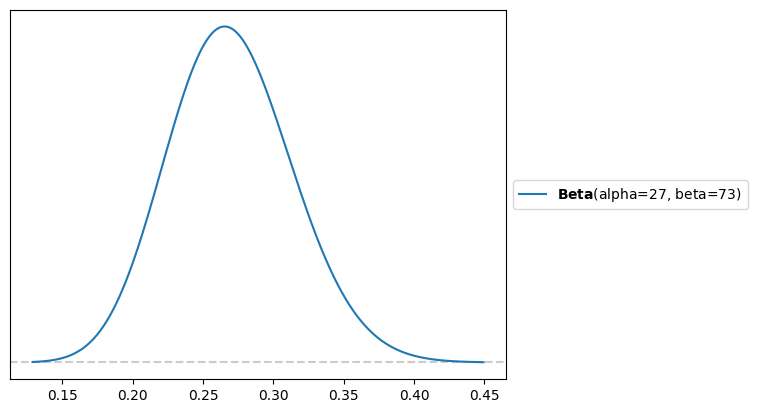

In [3]:
# Preliz function creating a beta distribution based on the established prior
prior = pz.Beta(alpha = 27, beta = 73)

# Graph of the prior's probability density function (pdf), as well as the mean, median and mode of the prior
prior.plot_pdf()
print("Median:", prior.median(), "Mean:", prior.mean(), "Mode:", (prior.alpha - 1)/(prior.alpha + prior.beta - 2))

As you can see, our prior expects Schwellenbach's strikeout rate to be somewhere around 27%, with the median, mean and mode all rounding to that number. The mean is the most bullish on Schwellenbach's strikeout rate, while the mode is the most bearish, but they're all pretty similar.

Spencer Schwellenbach struck out a total of 107 batters across 401 batters faced in 97.1 innings so far this season [according to FanGraphs](https://www.fangraphs.com/players/spencer-schwellenbach/31846/stats?position=P). We'll use this for the binomial distribution, or likelihood.

The below code outlines the beginning of a model meant to project Schwellenbach's "K-rate" (the shorthand for strikeout in the box score and colloquially is "K"). This is largely based on code from the Unit 2 notes.

In [4]:
# strikeouts
Ks_made = np.repeat(1, 107)

# non-strikeouts
Ks_lost = np.repeat(0, 294)

# strikeouts + non-strikeouts put into the same array
Ks_total = np.concatenate([Ks_made, Ks_lost])

with pm.Model() as schbach_K_model:

  # prior (using Beta distribution)
  θ = pm.Beta('θ', alpha = 27., beta = 73.)

  # likelihood (using binomial distribution)
  y = pm.Bernoulli('y', p = θ, observed = Ks_total)

  # sample from posterior
  Krate_data = pm.sample(1000)

Let's see what our model spat out:

<Axes: title={'center': 'θ'}>

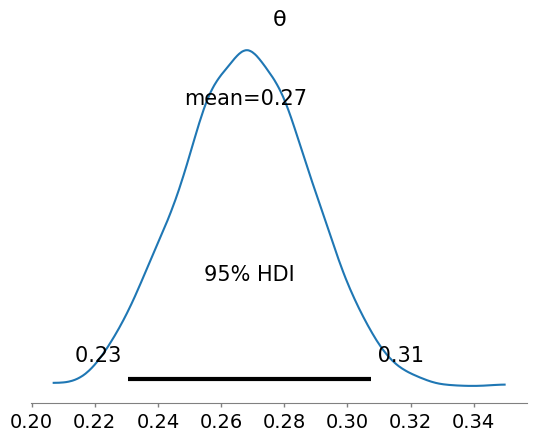

In [8]:
az.plot_posterior(Krate_data, hdi_prob=.95)

This looks pretty reasonable to me! The model's mean is a strikeout rate of 27%, which is what I projected (and the likelihood stated), with the upper bound of the HDI being 31% (an elite strikeout rate - this year only 3 pitchers exceeded that number, including both of the projected Cy Young Award winners) and the lower bound being 23% (about average). If there's anything wrong with this model, it's that it might be a bit too confident - I don't think ~100 innings is large enough of a sample size to confidentally shout "Spencer Schwellenbach is an above-average pitcher" to the heavens.